In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240918%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240918T135539Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ea8523391d1293e0ad2f381f55416a471db6f7a1960c08f2fe85a59ddb1d325a1300d8ce95bc2cafa450c62bfe5ba875fab9e0efe9abdcafdc686f543dcc00b686b2d29d0b134c85b5078c633fa00582b363c9cd59fbdc4399318977975f2c4574b7ce898391de0a3e485575049196b5d6516391d0fb82d10298e96282cd93f2dfbf8918078af6e46d5ae3371c11efb00e92aee6a21808b2d3b342af1cc91ffaec56d2a4ed1c8fcb5be9f7bae12885924ce11c2a4f2b2c9360075d358cd452aa172356b728b03295fa61de2e494b3a29a10752058990ffa5f3bf0797ebc19e0ee2de64962103018dba4e112c2c98a9505dd2e5716d7780d78537d8679030be7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1463_bacteria_3811.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1414_bacteria_3628.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1423_bacteria_3650.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person512_virus_1029.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person735_bacteria_2638.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1502_virus_2612.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person372_virus_755.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1230_bacteria_3185.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person70_bacteria_343.jpeg
/kaggle/input/chest-xray-pneumonia/che

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize the pixel values
    rotation_range=15,         # Randomly rotate images by 15 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally (10%)
    height_shift_range=0.1,    # Randomly shift images vertically (10%)
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'        # Fill missing pixels with the nearest pixel
)

# Load data from the directory
train_data = datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train',
    target_size=(224, 224),  # Resize to match input size for model
    batch_size=8,            # Small batch size for efficient training
    class_mode='categorical'  # Two classes: 'normal' and 'pneumonia'
)

validation_data = datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


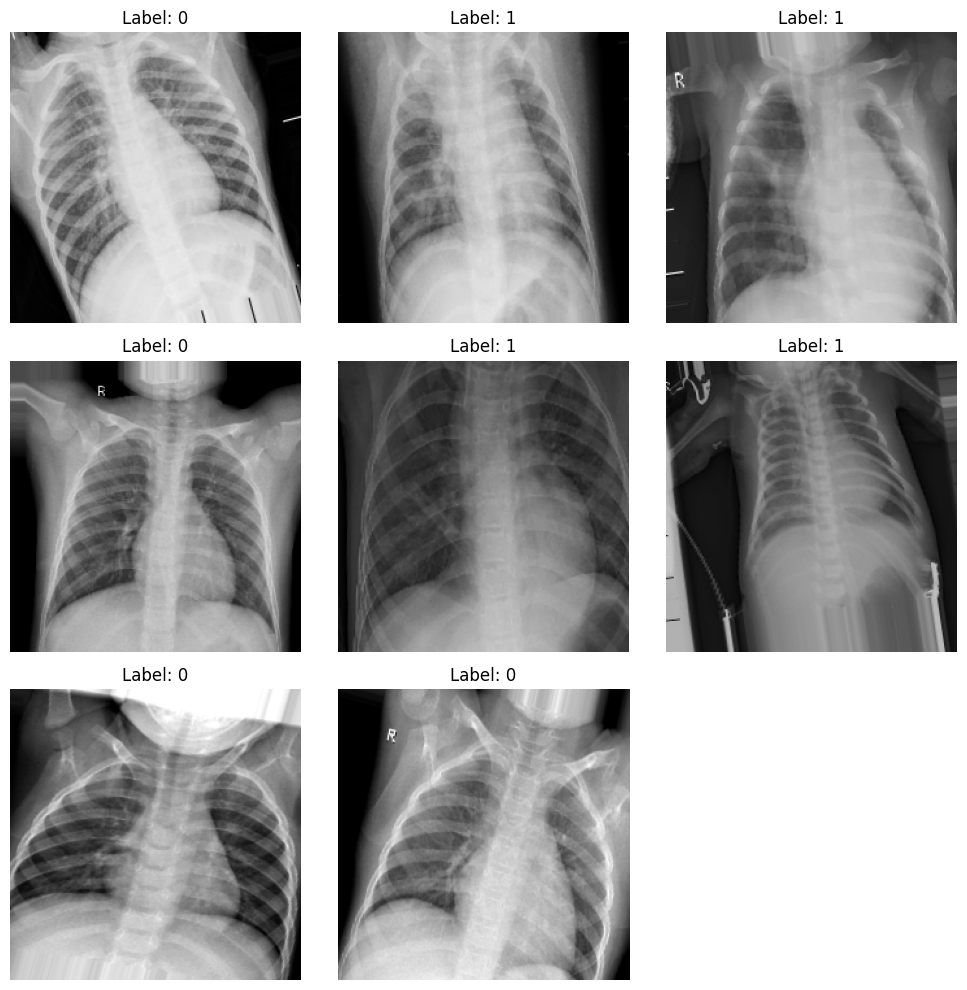

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_data)  # Fetch a single batch from the training data

# Plot the images
plt.figure(figsize=(10, 10))  # Set the figure size
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)  # Create a subplot for each image
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {np.argmax(labels[i])}")  # Show the label
    plt.axis('off')  # Turn off the axis for clarity
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.applications import ResNet50

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Reshape, MultiHeadAttention, LayerNormalization

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# EfficientNetB0 feature extraction
efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
efficient_net_output = GlobalAveragePooling2D()(efficient_net.output)

# DenseNet121 feature extraction
dense_net = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
dense_net_output = GlobalAveragePooling2D()(dense_net.output)

# Concatenate features from both networks
concatenated_features = Concatenate()([efficient_net_output, dense_net_output])

# Add Dropout for regularization
concatenated_features = Dropout(0.3)(concatenated_features)

# Reshape concatenated_features for MultiHeadAttention
# MultiHeadAttention expects input shape (batch_size, seq_len, feature_dim)
# Add a new dimension for seq_len (e.g., 1)
reshaped_features = Reshape((1, -1))(concatenated_features)

# Multi-head attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(reshaped_features, reshaped_features)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

# Flatten the attention output
flattened_output = tf.keras.layers.Flatten()(attention_output)

# Add a fully connected layer
x = Dense(512, activation='relu')(flattened_output)

# Final classification layer
outputs = Dense(2, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Example usage of model.fit
# model.fit(train_data, epochs=10, validation_data=val_data)


In [19]:
# Train the model
history = model.fit(train_data, validation_data=validation_data, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 429s 242ms/step - accuracy: 0.8425 - loss: 0.6148 - val_accuracy: 0.5000 - val_loss: 2.8834
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 145s 220ms/step - accuracy: 0.9430 - loss: 0.1694 - val_accuracy: 0.5000 - val_loss: 0.8656
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 143s 218ms/step - accuracy: 0.9438 - loss: 0.1470 - val_accuracy: 0.6250 - val_loss: 0.9766
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 150s 229ms/step - accuracy: 0.9429 - loss: 0.1527 - val_accuracy: 0.9375 - val_loss: 0.1281
Epoch 5/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 195s 218ms/step - accuracy: 0.9583 - loss: 0.1201 - val_accuracy: 0.9375 - val_loss: 0.1295


In [20]:
model.save("with_attention.h5")

In [22]:
# Image data generator for the test set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',  # Path to the test dataset
    target_size=(224, 224),  # Resize to match input size for model
    batch_size=8,            # Batch size can be the same as training
    class_mode='categorical',  # Two classes: 'normal' and 'pneumonia'
    shuffle=False            # Important: don't shuffle for evaluation
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')


Found 624 images belonging to 2 classes.
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9445 - loss: 0.1538
Test accuracy: 0.9070512652397156


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate on the test data
test_loss, test_acc = model.evaluate(test_data)

# Predict on test data to get confusion matrix, precision, recall, etc.
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = y_pred_probs.argmax(axis=1)

# Confusion Matrix
print(confusion_matrix(y_true, y_pred))

# Classification Report (precision, recall, f1-score)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# AUC score
auc = roc_auc_score(y_true, y_pred_probs[:, 1])
print(f"AUC: {auc}")